In [2]:
import math
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

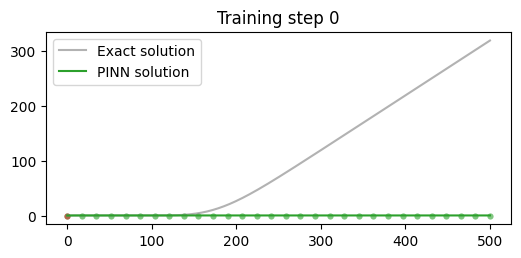

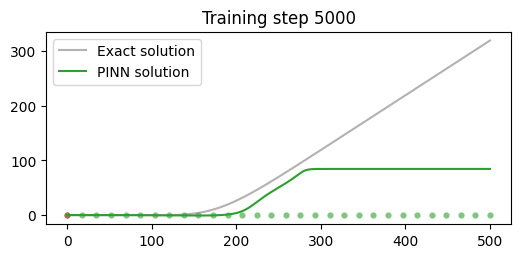

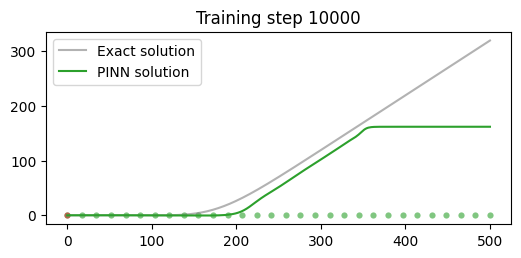

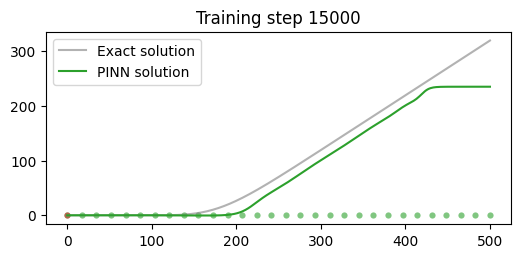

64.82555031776428
Final Loss: 5909.16064453125,Parameters: hidden_dimension:16 number of layers: 3 activation: tanh


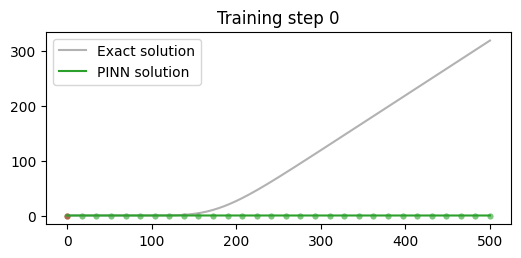

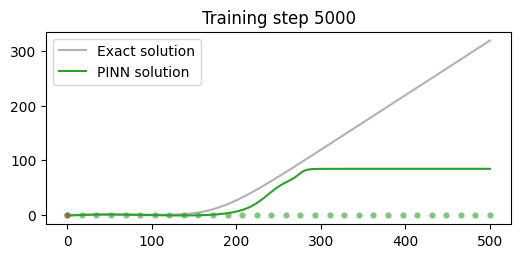

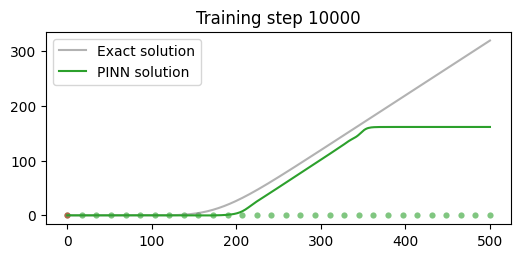

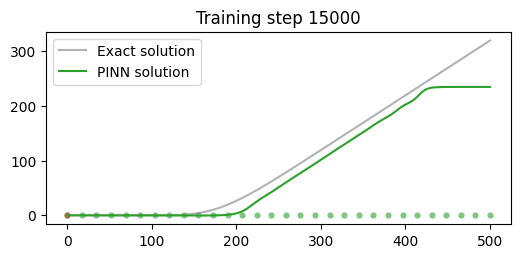

71.49688863754272
Final Loss: 5962.17919921875,Parameters: hidden_dimension:16 number of layers: 4 activation: tanh


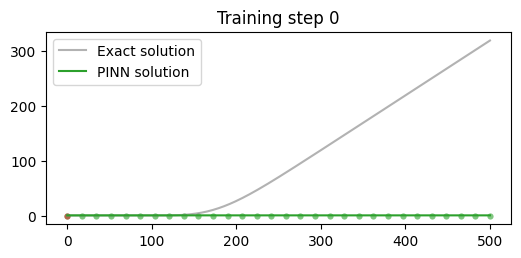

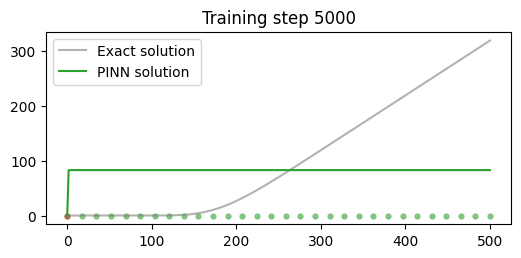

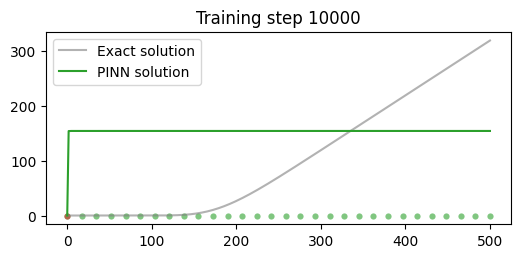

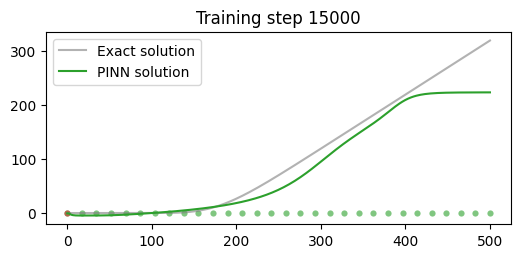

86.98103928565979
Final Loss: 7960.12109375,Parameters: hidden_dimension:16 number of layers: 6 activation: tanh


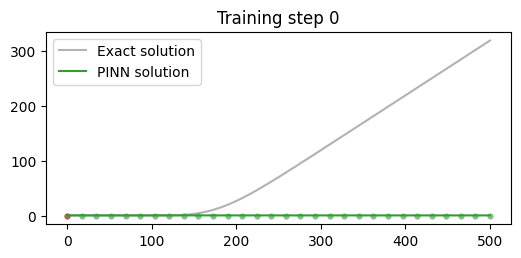

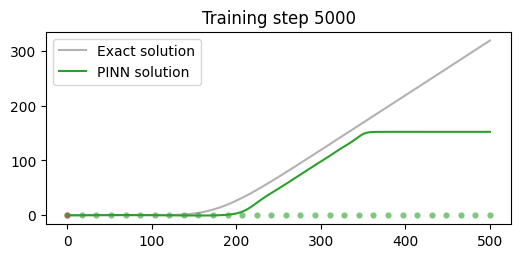

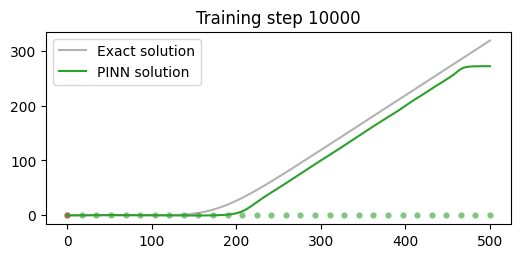

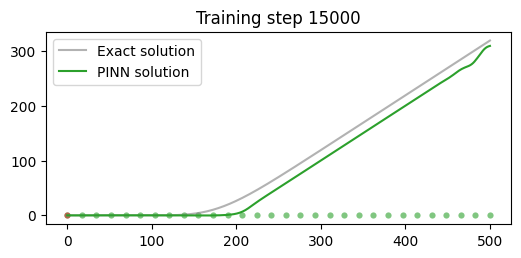

58.95368409156799
Final Loss: 16.242151260375977,Parameters: hidden_dimension:32 number of layers: 3 activation: tanh


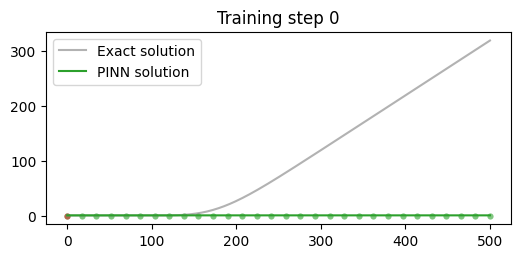

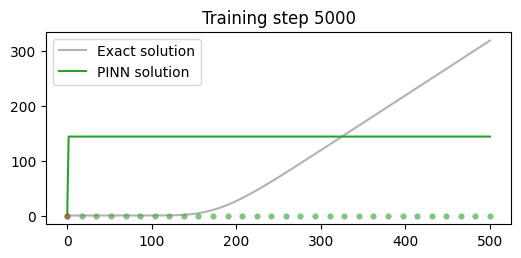

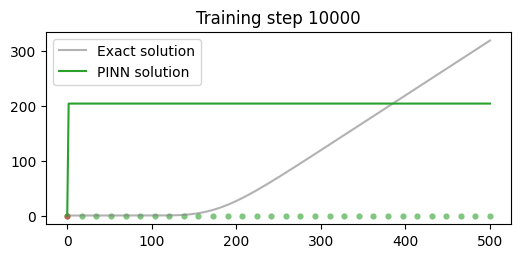

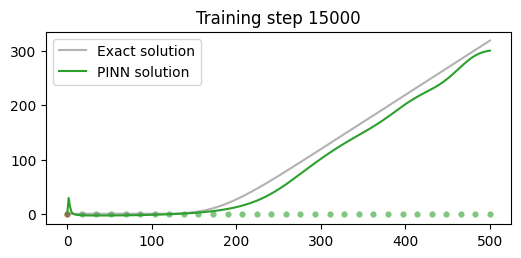

68.29893445968628
Final Loss: 93.80574798583984,Parameters: hidden_dimension:32 number of layers: 4 activation: tanh


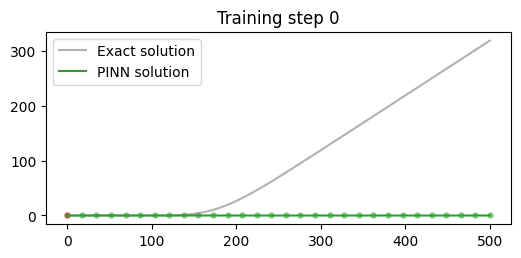

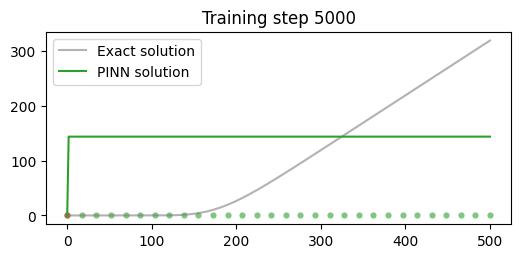

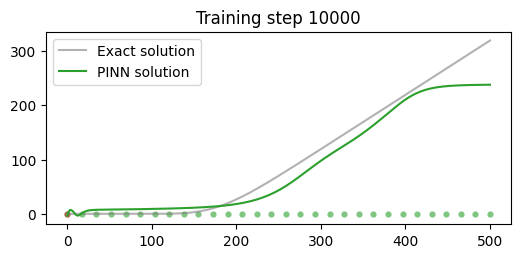

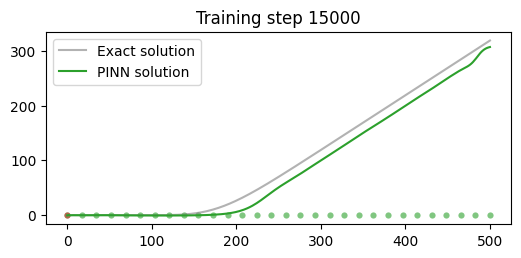

88.37801504135132
Final Loss: 38.722530364990234,Parameters: hidden_dimension:32 number of layers: 6 activation: tanh


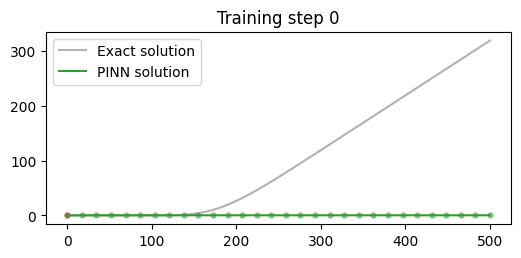

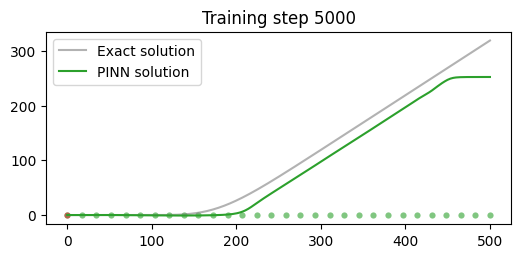

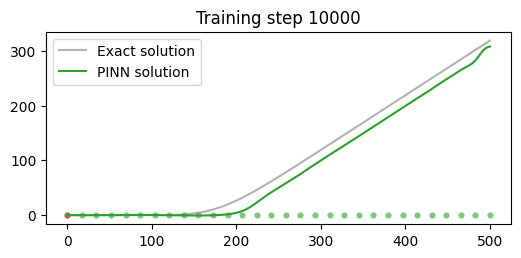

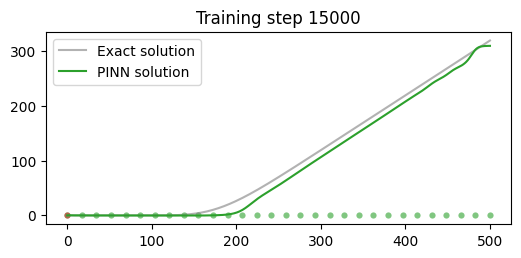

98.61410975456238
Final Loss: 56.14598846435547,Parameters: hidden_dimension:64 number of layers: 3 activation: tanh


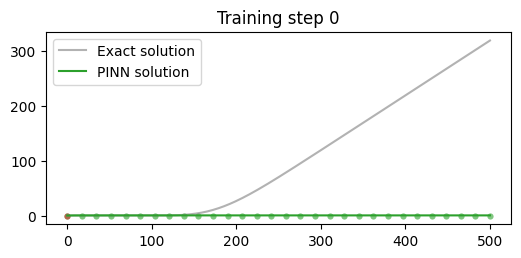

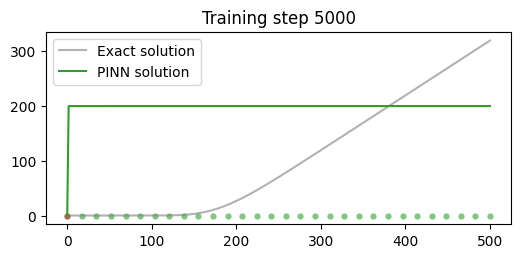

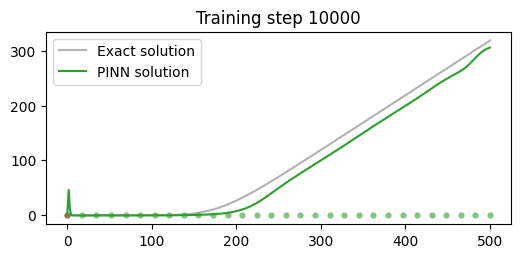

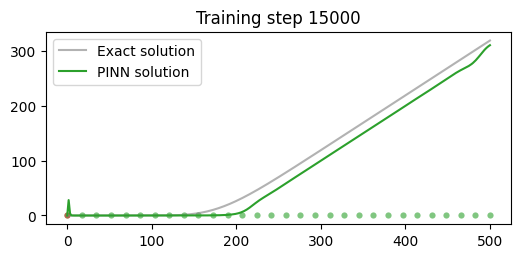

120.2921404838562
Final Loss: 7.982750415802002,Parameters: hidden_dimension:64 number of layers: 4 activation: tanh


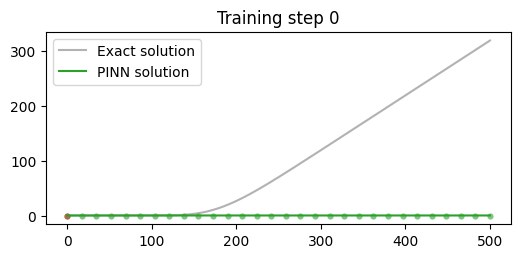

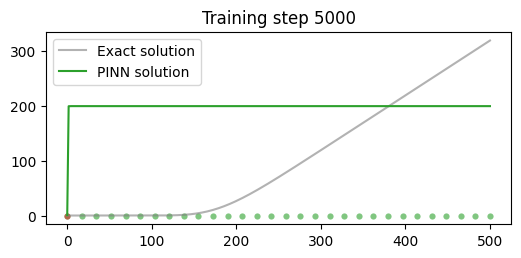

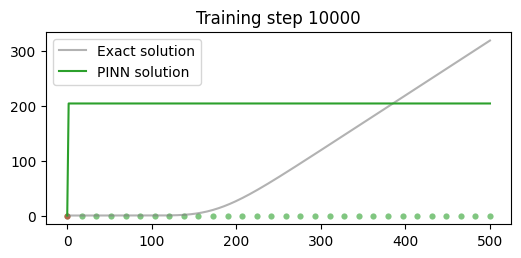

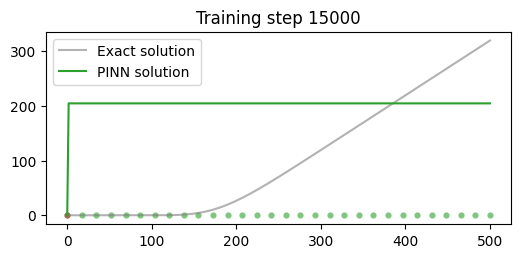

151.03175902366638
Final Loss: 32791.3203125,Parameters: hidden_dimension:64 number of layers: 6 activation: tanh


In [3]:
# Setting a manual seed for reproducibility
torch.manual_seed(123)

# Define the neural network model
class FCN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(FCN, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Define boundary points for the boundary loss
t_boundary = torch.tensor([0.0]).view(-1, 1).requires_grad_(True)
S_boundary_0 = torch.zeros(1, 1).requires_grad_(True)
S_boundary_inf = torch.tensor([500.0]).view(-1, 1).requires_grad_(True)

# Define training points over the entire domain for the physics loss
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
S_physics = torch.linspace(0, 500, 30).view(-1, 1).requires_grad_(True)

for hid_dim in [16, 32, 64]:
    for num_lay in [3, 4, 6]:
        # Initialize the neural network
        start_time = time.time()
        pinn = FCN(2, 1, hid_dim, num_lay)

        # Define the optimizer
        optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

        # Black-Scholes parameters
        K = 200.0
        T = 1.0
        r = 0.1
        sigma = 0.2

        # Define the exact solution for comparison (for visualization purposes)
        def exact_solution(S, t):
            d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * torch.sqrt(T - t))
            d2 = d1 - sigma * torch.sqrt(T - t)
            call_price = S * torch.distributions.Normal(0, 1).cdf(d1) - K * torch.exp(-r * (T - t)) * torch.distributions.Normal(0, 1).cdf(d2)
            return call_price

        # Training loop
        num_epochs = 15001
        
        for epoch in range(num_epochs):
            
            optimizer.zero_grad()
            
            # Compute boundary loss
            # Boundary at t = 0 (initial condition)
            S = S_physics
            t = torch.zeros_like(S)
            u = pinn(torch.cat((S, t), dim=1))
            payoff = torch.maximum(S - K, torch.tensor([0.0]))
            boundary_loss = torch.mean((u - payoff)**2)
            
            # Boundary at S = 0
            S = S_boundary_0.repeat(t_physics.size(0), 1)
            t = t_physics
            u = pinn(torch.cat((S, t), dim=1))
            zero_loss = torch.mean(u**2)
            
            # Boundary as S -> infinity
            S = S_boundary_inf.repeat(t_physics.size(0), 1)
            t = t_physics
            u = pinn(torch.cat((S, t), dim=1))
            inf_loss = torch.mean((u - (S - K * torch.exp(-r * (T - t))))**2)
            
            # Compute physics loss
            S = S_physics
            t = t_physics
            inputs = torch.cat((S, t), dim=1)
            u = pinn(inputs)
            dudt = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
            duds = torch.autograd.grad(u, S, torch.ones_like(u), create_graph=True)[0]
            d2uds2 = torch.autograd.grad(duds, S, torch.ones_like(duds), create_graph=True)[0]
            physics_loss = torch.mean((dudt + 0.5 * sigma**2 * S**2 * d2uds2 + r * S * duds - r * u)**2)
            
            # Total loss
            lambda1, lambda2 = 1e-1, 1e-4
            loss = boundary_loss + zero_loss + inf_loss + lambda2 * physics_loss
            
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            
            # Plot the result as training progresses
            if epoch % 5000 == 0:
                S_test = torch.linspace(0, 500, 300).view(-1, 1)
                t_test = torch.zeros_like(S_test)
                u_exact = exact_solution(S_test, t_test)
                u_pred = pinn(torch.cat((S_test, t_test), dim=1)).detach()
                end_time = time.time()
                plt.figure(figsize=(6, 2.5))
                plt.scatter(S_physics.detach()[:,0], 
                            torch.zeros_like(S_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
                plt.scatter(S_boundary_0.detach()[:,0], 
                            torch.zeros_like(S_boundary_0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
                plt.plot(S_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
                plt.plot(S_test[:,0], u_pred[:,0], label="PINN solution", color="tab:green")
                plt.title(f"Training step {epoch}")
                plt.legend()
                plt.show()
        
        print(end_time-start_time)
        print(f"Final Loss: {loss.item()},Parameters: hidden_dimension:{hid_dim} number of layers: {num_lay} activation: tanh")


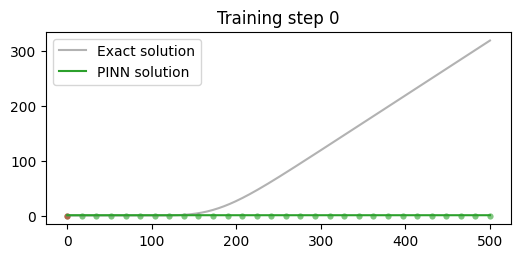

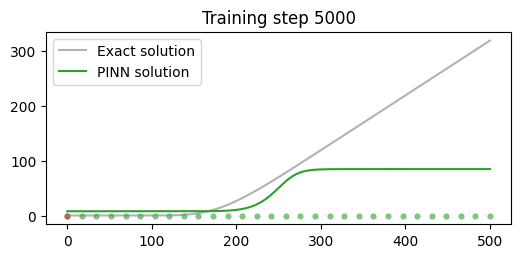

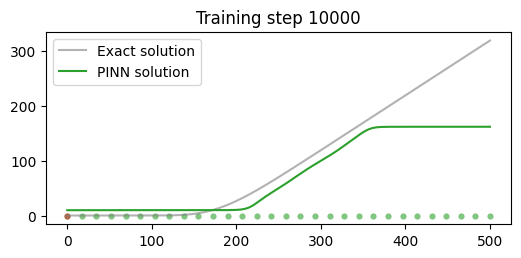

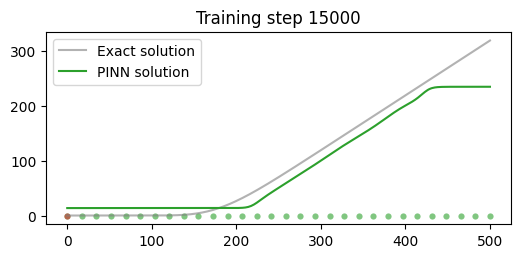

65.07469463348389
Final Loss: 6165.2763671875,Parameters: hidden_dimension:16 number of layers: 3 activation: Sigmoid


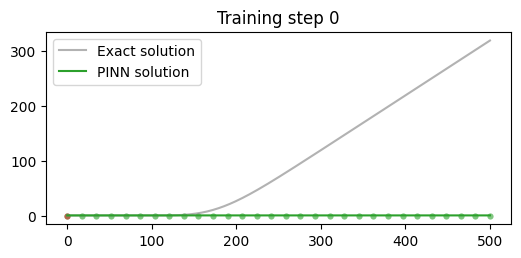

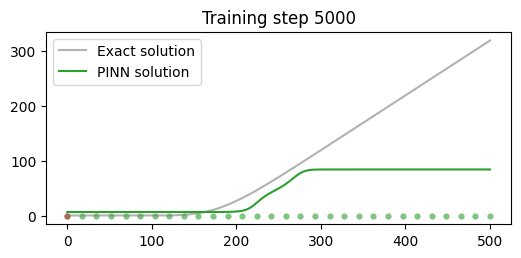

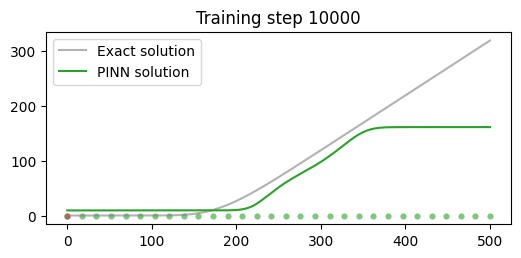

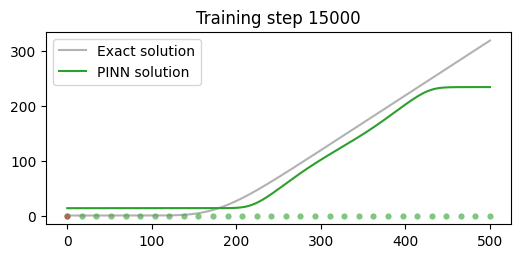

68.69625687599182
Final Loss: 6253.134765625,Parameters: hidden_dimension:16 number of layers: 4 activation: Sigmoid


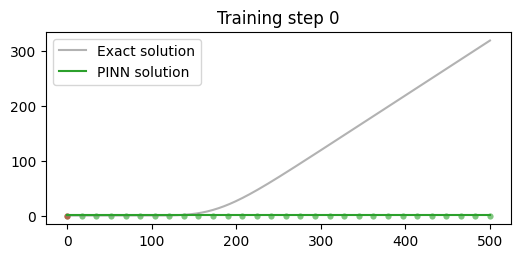

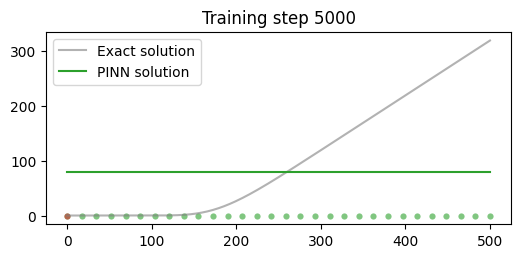

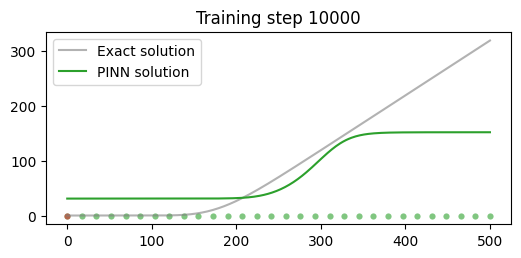

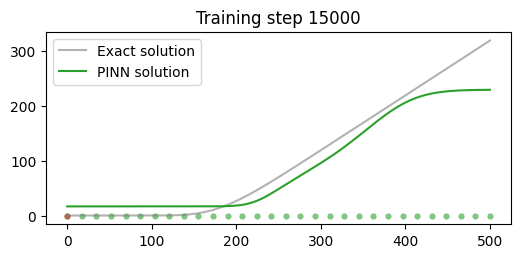

88.57441091537476
Final Loss: 7213.3984375,Parameters: hidden_dimension:16 number of layers: 6 activation: Sigmoid


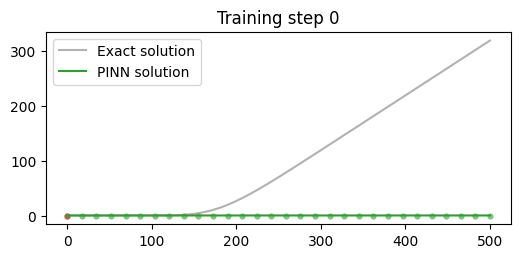

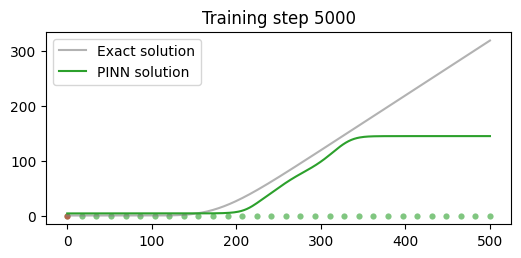

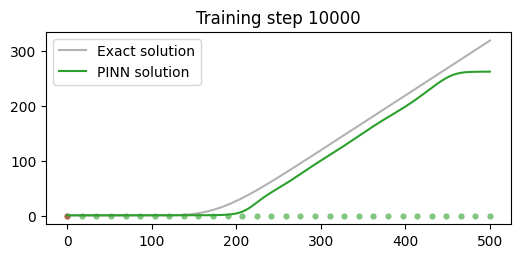

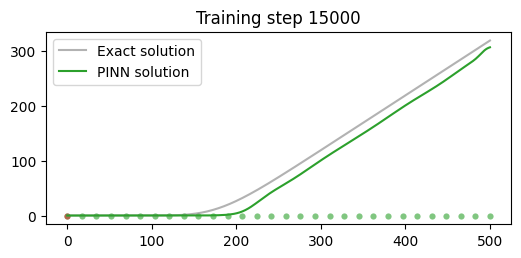

60.61339807510376
Final Loss: 36.453670501708984,Parameters: hidden_dimension:32 number of layers: 3 activation: Sigmoid


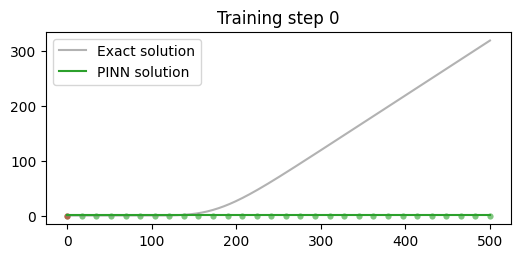

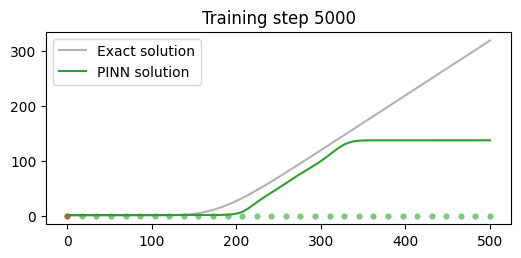

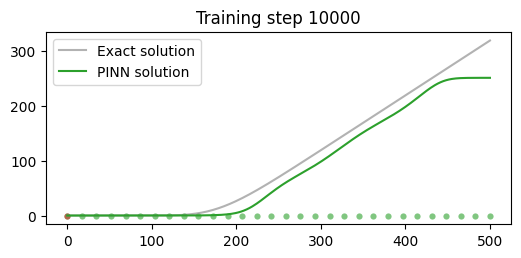

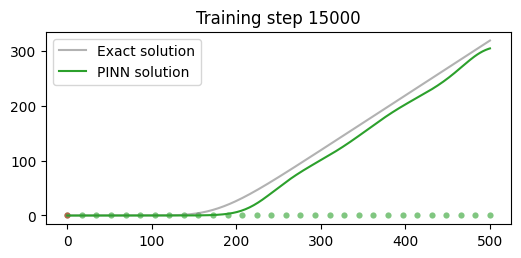

72.01183581352234
Final Loss: 42.41347122192383,Parameters: hidden_dimension:32 number of layers: 4 activation: Sigmoid


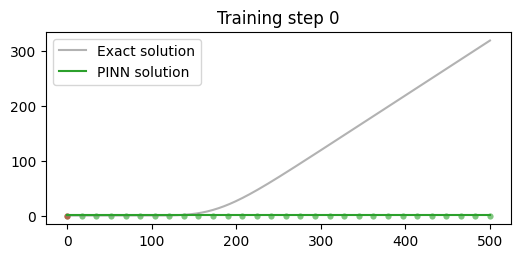

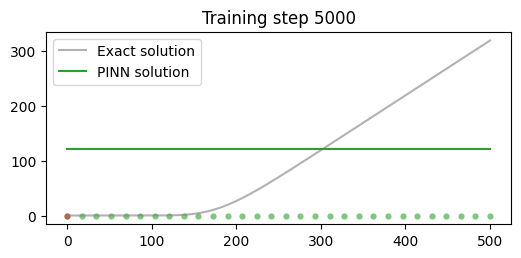

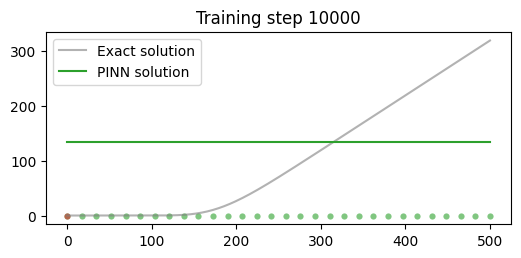

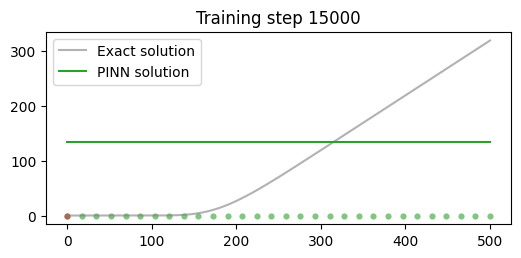

96.7282350063324
Final Loss: 61058.1640625,Parameters: hidden_dimension:32 number of layers: 6 activation: Sigmoid


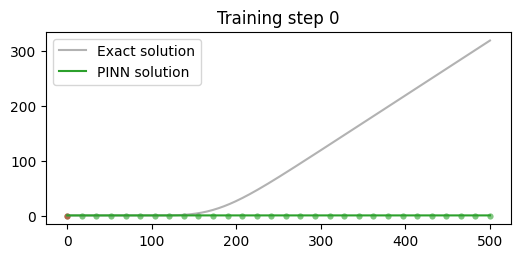

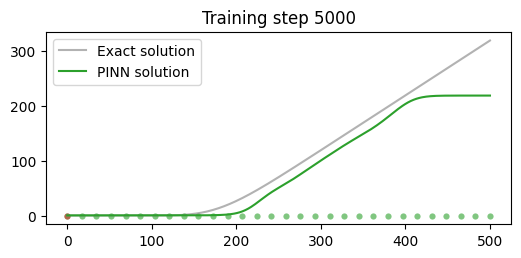

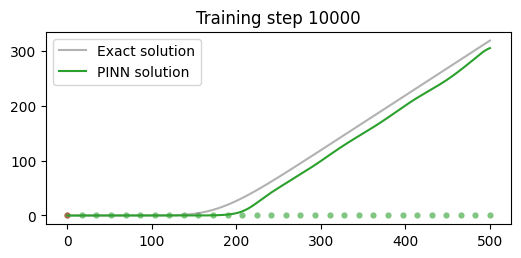

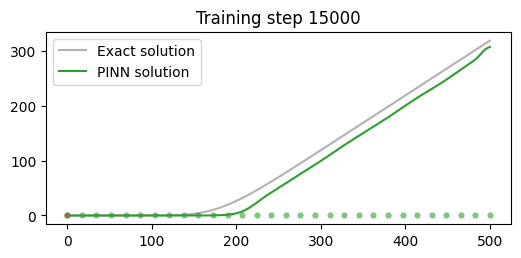

82.9436206817627
Final Loss: 36.06683349609375,Parameters: hidden_dimension:64 number of layers: 3 activation: Sigmoid


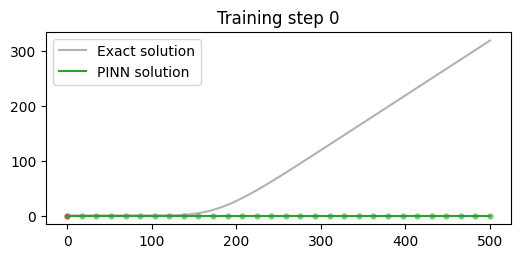

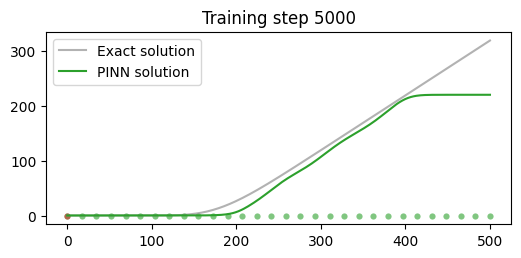

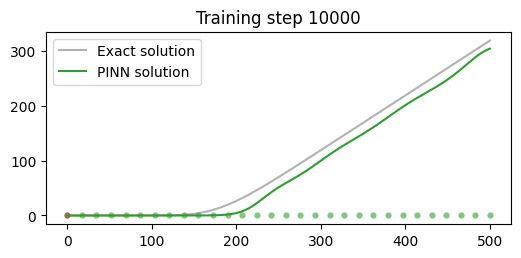

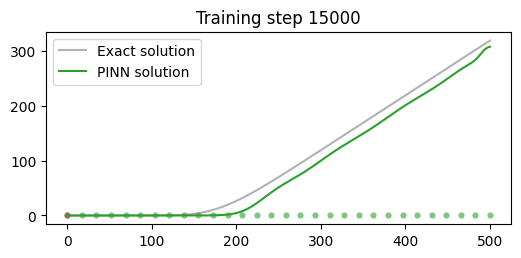

105.35723423957825
Final Loss: 36.084197998046875,Parameters: hidden_dimension:64 number of layers: 4 activation: Sigmoid


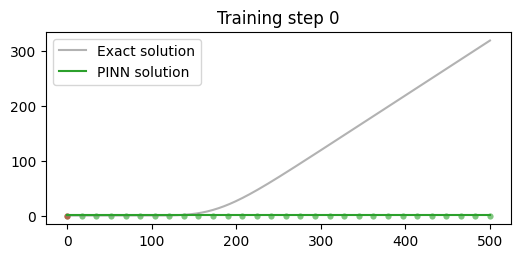

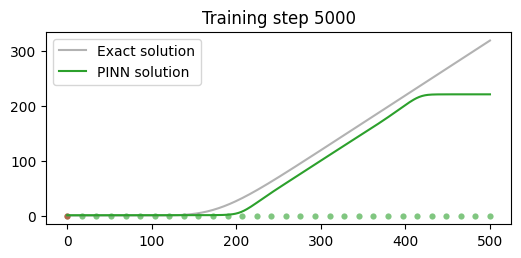

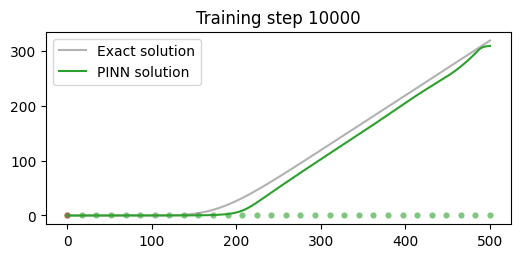

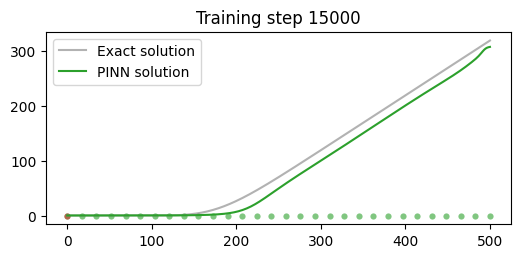

143.65169095993042
Final Loss: 39.092002868652344,Parameters: hidden_dimension:64 number of layers: 6 activation: Sigmoid


In [5]:
# Setting a manual seed for reproducibility
torch.manual_seed(123)

# Define the neural network model
class FCN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(FCN, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Sigmoid()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Define boundary points for the boundary loss
t_boundary = torch.tensor([0.0]).view(-1, 1).requires_grad_(True)
S_boundary_0 = torch.zeros(1, 1).requires_grad_(True)
S_boundary_inf = torch.tensor([500.0]).view(-1, 1).requires_grad_(True)

# Define training points over the entire domain for the physics loss
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
S_physics = torch.linspace(0, 500, 30).view(-1, 1).requires_grad_(True)

for hid_dim in [16, 32, 64]:
    for num_lay in [3, 4, 6]:
        # Initialize the neural network
        start_time = time.time()
        pinn = FCN(2, 1, hid_dim, num_lay)

        # Define the optimizer
        optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

        # Black-Scholes parameters
        K = 200.0
        T = 1.0
        r = 0.1
        sigma = 0.2

        # Define the exact solution for comparison (for visualization purposes)
        def exact_solution(S, t):
            d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * torch.sqrt(T - t))
            d2 = d1 - sigma * torch.sqrt(T - t)
            call_price = S * torch.distributions.Normal(0, 1).cdf(d1) - K * torch.exp(-r * (T - t)) * torch.distributions.Normal(0, 1).cdf(d2)
            return call_price

        # Training loop
        num_epochs = 15001
        for epoch in range(num_epochs):
            
            optimizer.zero_grad()
            
            # Compute boundary loss
            # Boundary at t = 0 (initial condition)
            S = S_physics
            t = torch.zeros_like(S)
            u = pinn(torch.cat((S, t), dim=1))
            payoff = torch.maximum(S - K, torch.tensor([0.0]))
            boundary_loss = torch.mean((u - payoff)**2)
            
            # Boundary at S = 0
            S = S_boundary_0.repeat(t_physics.size(0), 1)
            t = t_physics
            u = pinn(torch.cat((S, t), dim=1))
            zero_loss = torch.mean(u**2)
            
            # Boundary as S -> infinity
            S = S_boundary_inf.repeat(t_physics.size(0), 1)
            t = t_physics
            u = pinn(torch.cat((S, t), dim=1))
            inf_loss = torch.mean((u - (S - K * torch.exp(-r * (T - t))))**2)
            
            # Compute physics loss
            S = S_physics
            t = t_physics
            inputs = torch.cat((S, t), dim=1)
            u = pinn(inputs)
            dudt = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
            duds = torch.autograd.grad(u, S, torch.ones_like(u), create_graph=True)[0]
            d2uds2 = torch.autograd.grad(duds, S, torch.ones_like(duds), create_graph=True)[0]
            physics_loss = torch.mean((dudt + 0.5 * sigma**2 * S**2 * d2uds2 + r * S * duds - r * u)**2)
            
            # Total loss
            lambda1, lambda2 = 1e-1, 1e-4
            loss = boundary_loss + zero_loss + inf_loss + lambda2 * physics_loss
            
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            
            # Plot the result as training progresses
            if epoch % 5000 == 0:
                S_test = torch.linspace(0, 500, 300).view(-1, 1)
                t_test = torch.zeros_like(S_test)
                u_exact = exact_solution(S_test, t_test)
                u_pred = pinn(torch.cat((S_test, t_test), dim=1)).detach()
                end_time = time.time()
                plt.figure(figsize=(6, 2.5))
                plt.scatter(S_physics.detach()[:,0], 
                            torch.zeros_like(S_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
                plt.scatter(S_boundary_0.detach()[:,0], 
                            torch.zeros_like(S_boundary_0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
                plt.plot(S_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
                plt.plot(S_test[:,0], u_pred[:,0], label="PINN solution", color="tab:green")
                plt.title(f"Training step {epoch}")
                plt.legend()
                plt.show()
        
        print(end_time-start_time)
        print(f"Final Loss: {loss.item()},Parameters: hidden_dimension:{hid_dim} number of layers: {num_lay} activation: Sigmoid")


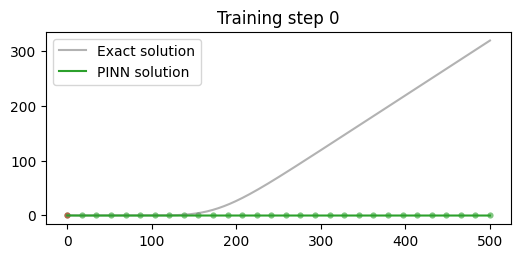

0.011976957321166992
Final Loss: 115053.75


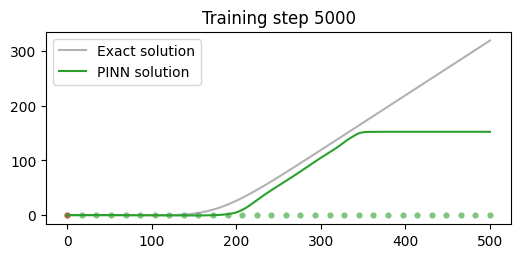

0.006884574890136719
Final Loss: 27233.96484375


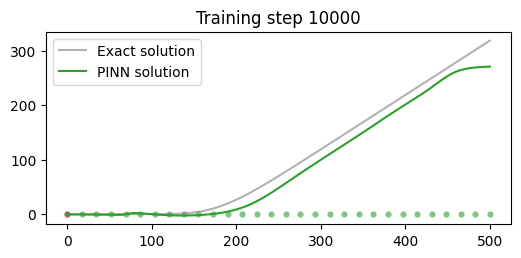

0.012439489364624023
Final Loss: 1498.5982666015625


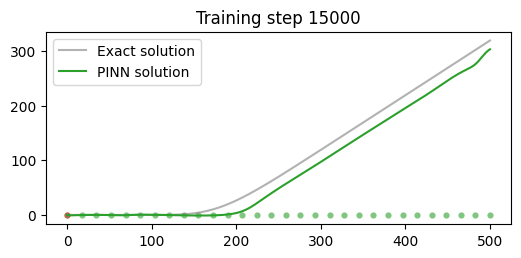

0.004393815994262695
Final Loss: 58.54892349243164


In [8]:
#Best Model

# Setting a manual seed for reproducibility
torch.manual_seed(123)

# Define the neural network model
class FCN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(FCN, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Define boundary points for the boundary loss
t_boundary = torch.tensor([0.0]).view(-1, 1).requires_grad_(True)
S_boundary_0 = torch.zeros(1, 1).requires_grad_(True)
S_boundary_inf = torch.tensor([500.0]).view(-1, 1).requires_grad_(True)

# Define training points over the entire domain for the physics loss
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
S_physics = torch.linspace(0, 500, 30).view(-1, 1).requires_grad_(True)


# Initialize the neural network
pinn = FCN(2, 1, 32, 3)

# Define the optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# Black-Scholes parameters
K = 200.0
T = 1.0
r = 0.1
sigma = 0.2

# Define the exact solution for comparison (for visualization purposes)
def exact_solution(S, t):
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * torch.sqrt(T - t))
    d2 = d1 - sigma * torch.sqrt(T - t)
    call_price = S * torch.distributions.Normal(0, 1).cdf(d1) - K * torch.exp(-r * (T - t)) * torch.distributions.Normal(0, 1).cdf(d2)
    return call_price

# Training loop
num_epochs = 15001
for epoch in range(num_epochs):
    start_time = time.time()
    optimizer.zero_grad()
    
    # Compute boundary loss
    # Boundary at t = 0 (initial condition)
    S = S_physics
    t = torch.zeros_like(S)
    u = pinn(torch.cat((S, t), dim=1))
    payoff = torch.maximum(S - K, torch.tensor([0.0]))
    boundary_loss = torch.mean((u - payoff)**2)
    
    # Boundary at S = 0
    S = S_boundary_0.repeat(t_physics.size(0), 1)
    t = t_physics
    u = pinn(torch.cat((S, t), dim=1))
    zero_loss = torch.mean(u**2)
    
    # Boundary as S -> infinity
    S = S_boundary_inf.repeat(t_physics.size(0), 1)
    t = t_physics
    u = pinn(torch.cat((S, t), dim=1))
    inf_loss = torch.mean((u - (S - K * torch.exp(-r * (T - t))))**2)
    
    # Compute physics loss
    S = S_physics
    t = t_physics
    inputs = torch.cat((S, t), dim=1)
    u = pinn(inputs)
    dudt = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    duds = torch.autograd.grad(u, S, torch.ones_like(u), create_graph=True)[0]
    d2uds2 = torch.autograd.grad(duds, S, torch.ones_like(duds), create_graph=True)[0]
    physics_loss = torch.mean((dudt + 0.5 * sigma**2 * S**2 * d2uds2 + r * S * duds - r * u)**2)
    
    # Total loss
    lambda1, lambda2 = 1e-1, 1e-4
    loss = boundary_loss + zero_loss + inf_loss + lambda2 * physics_loss
    
    # Backpropagation and optimization
    loss.backward()
    optimizer.step()
    
    # Plot the result as training progresses
    if epoch % 5000 == 0:
        S_test = torch.linspace(0, 500, 300).view(-1, 1)
        t_test = torch.zeros_like(S_test)
        u_exact = exact_solution(S_test, t_test)
        u_pred = pinn(torch.cat((S_test, t_test), dim=1)).detach()
        end_time = time.time()
        plt.figure(figsize=(6, 2.5))
        plt.scatter(S_physics.detach()[:,0], 
                    torch.zeros_like(S_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(S_boundary_0.detach()[:,0], 
                    torch.zeros_like(S_boundary_0)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(S_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(S_test[:,0], u_pred[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {epoch}")
        plt.legend()
        plt.show()
    
        print(end_time-start_time)
        print(f"Final Loss: {loss.item()}")